In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

sp500 = pd.read_csv("/Users/douglasallen/Library/CloudStorage/GoogleDrive-deallen1989@gmail.com/My Drive/Northeastern/Machine Learning/Final/Raw Data/SP500.csv")

In [2]:
print("First 10 Days of S&P500 Data\n", sp500.head(10))

First 10 Days of S&P500 Data
         Date     Open     High      Low   Close*  Adj Close**      Volume
0   2-Nov-22  3852.90  3894.44  3758.68  3759.69      3759.69  4899000000
1   1-Nov-22  3901.79  3911.79  3843.80  3856.10      3856.10  4481210000
2  31-Oct-22  3881.85  3893.73  3863.18  3871.98      3871.98  4820620000
3  28-Oct-22  3808.26  3905.42  3808.26  3901.06      3901.06  4459410000
4  27-Oct-22  3834.69  3859.95  3803.79  3807.30      3807.30  4687320000
5  26-Oct-22  3825.97  3886.15  3824.07  3830.60      3830.60  4817310000
6  25-Oct-22  3799.44  3862.85  3799.44  3859.11      3859.11  4843120000
7  24-Oct-22  3762.01  3810.74  3741.65  3797.34      3797.34  4747930000
8  21-Oct-22  3657.10  3757.89  3647.42  3752.75      3752.75  5078020000
9  20-Oct-22  3689.05  3736.00  3656.44  3665.78      3665.78  4496620000


Convert Date column to pandas datetime object, trim data to Jan 1 2022 and onward, and make chronological

In [3]:
sp500['DateTime'] = pd.to_datetime(sp500['Date'])
sp500['DateTime'] = np.where(sp500['DateTime'].dt.year > 2022, sp500['DateTime'] - pd.offsets.DateOffset(years=100), sp500['DateTime'])
# Anything after 2022 is changed to have 100 years subtracted because 2022 is the current year, change it as the years progress
sp500 = sp500.loc[(sp500['DateTime']>='2021-01-01')&(sp500['DateTime']<='2021-12-31')]
sp500 = sp500.loc[::-1].reset_index(drop=True)
print(sp500.head())


       Date     Open     High      Low   Close*  Adj Close**      Volume  \
0  4-Jan-21  3764.61  3769.99  3662.71  3700.65      3700.65  5006680000   
1  5-Jan-21  3698.02  3737.83  3695.07  3726.86      3726.86  4582620000   
2  6-Jan-21  3712.20  3783.04  3705.34  3748.14      3748.14  6049970000   
3  7-Jan-21  3764.71  3811.55  3764.71  3803.79      3803.79  5080870000   
4  8-Jan-21  3815.05  3826.69  3783.60  3824.68      3824.68  4764180000   

    DateTime  
0 2021-01-04  
1 2021-01-05  
2 2021-01-06  
3 2021-01-07  
4 2021-01-08  


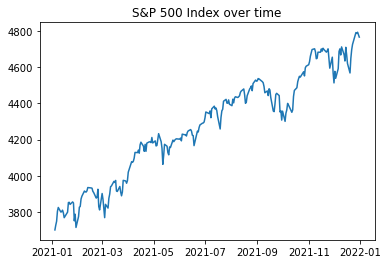

In [4]:
plt.plot(sp500['DateTime'],sp500['Adj Close**'])
plt.title("S&P 500 Index over time")
plt.show()

Perform Log Return Transformation

In [5]:
sp500['log_return'] = 0
for i in range(sp500.shape[0]-1):
    sp500.loc[i,'log_return'] = np.log(sp500.loc[i,'Adj Close**']/sp500.loc[i+1,'Adj Close**'])

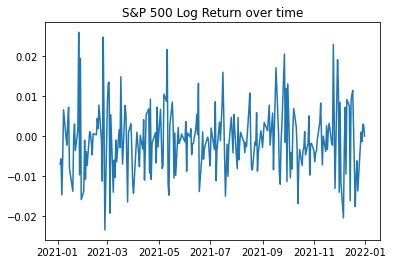

In [6]:
start_date = '1962-01-01'
plt.plot(sp500[sp500['DateTime']>=start_date]['DateTime'],sp500[sp500['DateTime']>=start_date]['log_return'])
plt.title("S&P 500 Log Return over time")
plt.show()

Transform price into log price for time series fitting

In [7]:
sp500['log_price'] = np.log(sp500['Adj Close**'])

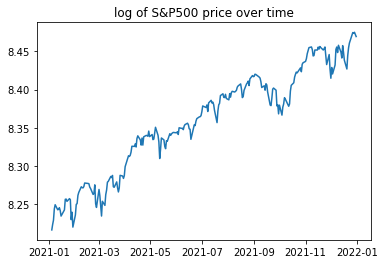

In [8]:
plt.plot(sp500['DateTime'],sp500['log_price'])
plt.title("log of S&P500 price over time")
plt.show()

Residuals are centered at 0 but not independent from time - there is periodicity

[0.00089974]


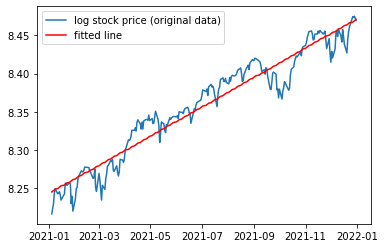

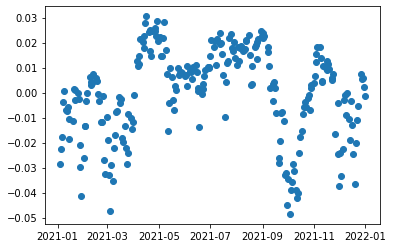

In [9]:
from sklearn import linear_model
clf = linear_model.LinearRegression()
index = sp500.reset_index().index.values.reshape(-1,1)

clf.fit(index, sp500['log_price'])
print(clf.coef_) # To print the coefficient estimate of the series. 
linear_prediction = clf.predict(index)
plt.plot(sp500['DateTime'], sp500['log_price'], label='log stock price (original data)')
plt.plot(sp500['DateTime'], linear_prediction, 'r', label='fitted line')
plt.legend()
plt.show()
linear_residuals = sp500['log_price'] - linear_prediction
plt.plot(sp500['DateTime'], linear_residuals, 'o')
plt.show();

                               SARIMAX Results                                
Dep. Variable:              log_price   No. Observations:                  222
Model:                 ARIMA(2, 0, 2)   Log Likelihood                 759.165
Date:                Mon, 12 Dec 2022   AIC                          -1506.330
Time:                        01:07:34   BIC                          -1485.914
Sample:                             0   HQIC                         -1498.087
                                - 222                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.3456      0.062    135.385      0.000       8.225       8.466
ar.L1          0.8513      1.128      0.755      0.451      -1.360       3.063
ar.L2          0.1416      1.120      0.126      0.8

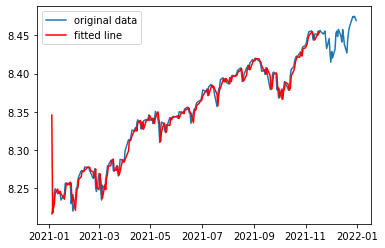

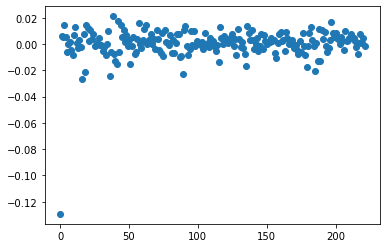

MSE with AR(1) model: 0.0001356932117738738


In [10]:
from statsmodels.tsa.arima.model import ARIMA
AR_order = 2
AR_differentiation = 0
MA_order = 2

days_to_predict = 30
training_days = sp500.iloc[0:sp500.shape[0]-days_to_predict]['DateTime']
train_price = sp500.iloc[0:sp500.shape[0]-days_to_predict]['log_price']
sp500_arima = ARIMA(train_price, order=(AR_order, AR_differentiation, MA_order)).fit()
print(sp500_arima.summary())
ar_higher_predictions = sp500_arima.predict()
ar_higher_residuals = train_price - ar_higher_predictions
ar_higher_residuals = ar_higher_residuals # Fitting AR 1 model means removing one observation
plt.plot(sp500['DateTime'],sp500['log_price'], label='original data')
plt.plot(training_days,ar_higher_predictions, 'r', label='fitted line')
plt.legend()
plt.show()
plt.plot(ar_higher_residuals, 'o')
plt.show()
print("MSE with AR(1) model:", np.mean(ar_higher_residuals**2))


No handles with labels found to put in legend.


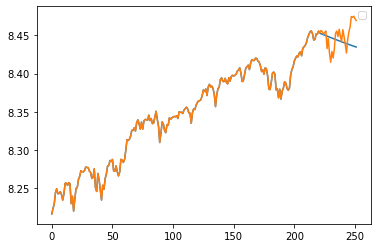

In [11]:
fcast = sp500_arima.get_forecast(30).summary_frame()
forecast_means = fcast['mean']

train_and_predict = pd.concat([train_price,forecast_means])

plt.plot(train_and_predict)
plt.plot(sp500['log_price'])
plt.legend()
plt.show()